# Load the required Python libraries

In [138]:
import os
import numpy as np
import pandas as pd

import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode
import shutil
from PIL import Image  # To create gifs

from Mapfct import *     # Here is where we call the function.
from Crossfct import *   # Here is where we call the function.

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Chlorophyll change

## Load dataset into xArray

In [139]:
ds = xr.open_mfdataset("ds_bio_chl.nc")
ds.head()

<xarray.Dataset>
Dimensions:    (time: 5, latitude: 5, longitude: 5)
Coordinates:
    zc         float64 ...
  * time       (time) datetime64[ns] 2010-12-31T14:00:00 ... 2011-04-30T14:00:00
  * latitude   (latitude) float64 -28.7 -28.67 -28.64 -28.61 -28.58
  * longitude  (longitude) float64 142.2 142.2 142.2 142.3 142.3
Data variables:
    Chl_a_sum  (time, latitude, longitude) float32 dask.array<chunksize=(5, 5, 5), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                     CF-1.0
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    RunID:                           2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2021-09-08T01:59:05+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__GBR4_H2p0...
    ...                              ...
    paramfile:                       /home/bai155/EMS_solar2/gbr4_H2p0_B3p1_C...
    paramhead:                       eReefs 4 km grid. SOURCE Catchments with...
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 BioGeoChemical 3....
    DODS_EXTRA.Unlimited_Dimension:  time

## Chlorophyll variation Linear fitting

Here we do the linear fitting between chlorophyll a and time index, and take the coeffients at every map points, to show the overall changes in chlorophyll a in the Great Barrier Reef. 

First, we replace the time index(number of months) with the oringinal time coordanate. So it will be easier for calculation and the coeffients will be in accordiance with we did in other notebooks.


In [140]:
#replace with time index
timeIndex = [i+1 for i in range(len(ds.time))]
newDataArray = ds.Chl_a_sum.assign_coords(time=timeIndex)

After that, we use the Dataset.polyfit()function in xarray to do the linear fitting and return a summay results dataset. We use the variable "polyfit_coefficients" for the afterwards mapping and calculation,in which degree=1 points to the coeffient and degree=0 points to the constant of the fitting line.

In [141]:
# use the polyfit function to do linear fitting
res = newDataArray.polyfit(dim='time',deg=1)
res

<xarray.Dataset>
Dimensions:               (degree: 2, latitude: 723, longitude: 491)
Coordinates:
  * degree                (degree) int32 1 0
  * latitude              (latitude) float64 -28.7 -28.67 ... -7.066 -7.036
  * longitude             (longitude) float64 142.2 142.2 142.2 ... 156.8 156.9
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 dask.array<chunksize=(2, 723, 491), meta=np.ndarray>

## Define the location of the 5 sites

In [6]:
locA_lat = -27.405408
locA_lon = 153.783334
locB_lat = -24.321492
locB_lon = 153.491998
locC_lat = -20.309551
locC_lon = 151.150283
locD_lat = -17.50165
locD_lon = 146.911291
locE_lat = -12.084213
locE_lon = 144.081379

## Plot the Coefficients map

In [142]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the coefficients between chlorophyll a and time index at -60m depth
cf = res.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.Chl_a_sum.long_name+' concentration  '+ds.Chl_a_sum.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean Chlorophyll-a concentrations between 2011 and 2019 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
plt.savefig('chl-60.png',dpi=300, bbox_inches='tight')
# plt.show()
fig.clear()
plt.close(fig)
plt.clf()

<Figure size 432x288 with 0 Axes>

## Get the total Chlorophyll change

Now we want to calculate the total chlorophyll-a variance among the whole Great Barrier Reef region.

Define the linear fitting function of all the points on the map to be y = mx+b, then m equals to the mean of polyfit coefficients(degree=1), b equals to the mean of polyfit coefficients(degree=0).

Then the total percentage of variance of Chlorophyll should be m*(total months)/b*100. Total months points to the length of x thus the length of time index.

In [114]:
dm = res.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()


degree                  1.000000
polyfit_coefficients   -0.000208
dtype: float64

In [115]:
db = res.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()


degree                  0.00000
polyfit_coefficients    0.54395
dtype: float64

In [92]:
m=-0.000208
b=0.543950
perc = m*8*12/b*100
print(f'percentage = {round(perc,4)}%')

percentage = -3.6709%


# Temperature change

Here we do the same thing as above, with the sea surface temperature(-0.5m) and the temperature at -60m.

## Temperature variation at -60m

In [107]:
ds = xr.open_mfdataset("ds_bio_t.nc")
ds = ds.temp

In [108]:
#replace with time index
timeIndex = [i+1 for i in range(len(ds.time))]
newDataArray = ds.assign_coords(time=timeIndex)

#use the polyfit function to do linear fitting
rest = newDataArray.polyfit(dim='time',deg=1)
rest

<xarray.Dataset>
Dimensions:               (degree: 2, latitude: 723, longitude: 491)
Coordinates:
  * degree                (degree) int32 1 0
  * latitude              (latitude) float64 -28.7 -28.67 ... -7.066 -7.036
  * longitude             (longitude) float64 142.2 142.2 142.2 ... 156.8 156.9
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 dask.array<chunksize=(2, 723, 491), meta=np.ndarray>

## Total temperature change -60m

In [126]:
dm = rest.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()

degree                  1.000000
polyfit_coefficients    0.017894
dtype: float64

In [128]:
db = rest.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()

degree                   0.000000
polyfit_coefficients    25.236108
dtype: float64

In [130]:
m=0.017894
b=25.236108
perc = m*8*12/b*100
print(f'temperature % change -60m = {round(perc,4)}%')

temperature % change -60m = 6.807%


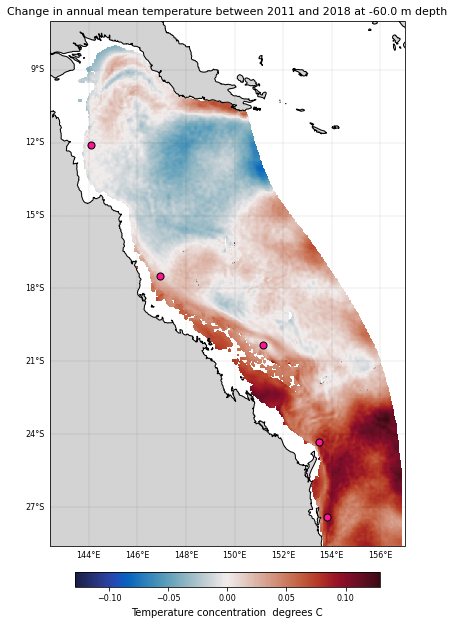

<Figure size 432x288 with 0 Axes>

In [110]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = rest.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.long_name+' concentration  '+ds.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean temperature between 2011 and 2018 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()
# plt.savefig('temp-60.png',dpi=300, bbox_inches='tight')
fig.clear()
plt.close(fig)
plt.clf()

## Temperature variation at -0.5m

In [111]:
ds = xr.open_mfdataset("ds_bio_t0.nc")
ds = ds.temp

In [112]:
timeIndex = [i+1 for i in range(len(ds.time))]

newDataArray = ds.assign_coords(time=timeIndex)
# newDataArray
rest0 = newDataArray.polyfit(dim='time',deg=1)
rest0

<xarray.Dataset>
Dimensions:               (degree: 2, latitude: 723, longitude: 491)
Coordinates:
  * degree                (degree) int32 1 0
  * latitude              (latitude) float64 -28.7 -28.67 ... -7.066 -7.036
  * longitude             (longitude) float64 142.2 142.2 142.2 ... 156.8 156.9
Data variables:
    polyfit_coefficients  (degree, latitude, longitude) float64 dask.array<chunksize=(2, 723, 491), meta=np.ndarray>

## Total temperature change -0.5m

In [132]:
dm = rest0.polyfit_coefficients.sel(degree=1).to_dataframe()
dm.mean()

degree                  1.000000
polyfit_coefficients    0.016508
dtype: float64

In [133]:
db = rest0.polyfit_coefficients.sel(degree=0).to_dataframe()
db.mean()

degree                   0.000000
polyfit_coefficients    26.542261
dtype: float64

In [135]:
m=0.016508
b=26.542261
perc = m*8*12/b*100
print(f'temperature % change -0.5m = {round(perc,4)}%')

temperature % change -0.5m = 5.9707%


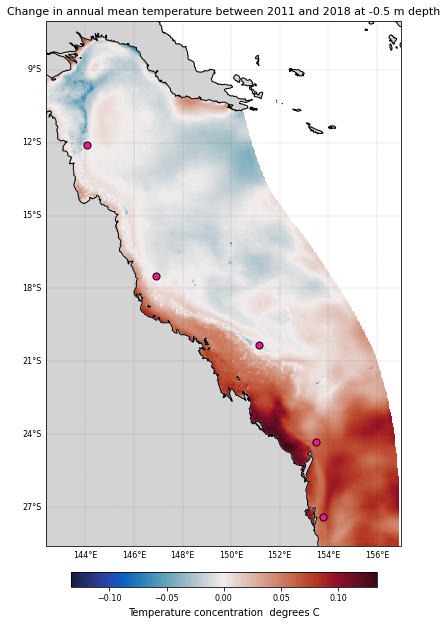

<Figure size 432x288 with 0 Axes>

In [119]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())

# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = rest0.polyfit_coefficients.sel(degree=1).plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    
    add_colorbar=False
)


# Color bar
cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                    orientation="horizontal")
cbar.set_label(ds.long_name+' concentration  '+ds.units, rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Title
plt.title('Change in annual mean temperature between 2011 and 2018 at '+str(ds.zc.values.item(-1))+' m depth',
          fontsize=11
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Site Davies Reef
ax.scatter(locA_lon, locA_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locB_lon, locB_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locC_lon, locC_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locD_lon, locD_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
ax.scatter(locE_lon, locE_lat, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()
# plt.savefig('temp-0.5.png',dpi=300, bbox_inches='tight')
fig.clear()
plt.close(fig)
plt.clf()